In [2]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from wtte.objectives.tensorflow import loglik_discrete, betapenalty
#output_notebook()

It is very telling to visualize the failures. What we can observe: we can observe the last time that the hardrive was seen in the data set. If the hard drive is no longer in the data set, it has failed, or has it just been removed from the data set? Our U matrix will be a mask the denotes censored drives, and most of our drives are censored. 

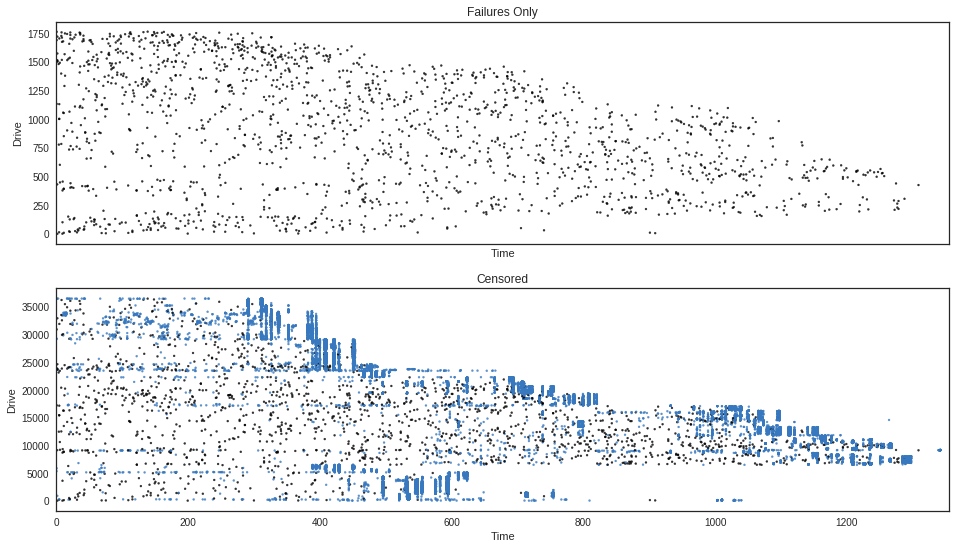

In [4]:
pf = "../survival_data/survival_ST4000DM000.csv"
df = pd.read_csv(pf, header=0)
day = 24.0
df_failures_only = df[df['failure'] ==1]
ttf = df_failures_only['runtime_max']/day
ttf_cen = df['runtime_max']/day

u_train = np.abs(df_failures_only['failure']-1)
u_train_cen = np.abs(df['failure']-1)

sns.set_style("white")
sns.despine(offset=10, trim=True);
colorp =sns.xkcd_palette(["windows blue", "black", "amber", "greyish"])
sns.set_palette(colorp)
u_colors = [colorp[0] if c==1 else colorp[1] for c in u_train]
u_colors_cen = [colorp[0] if c==1 else colorp[1] for c in u_train_cen]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
ax1.scatter(ttf, range(len(ttf)), c=u_colors, s=4, alpha=.8)
ax2.scatter(ttf_cen, range(len(ttf_cen )), c = u_colors_cen, s=4, alpha=.8)
ax1.set_ylabel('Drive')
ax2.set_ylabel('Drive')
ax1.set_title("Failures Only")
ax2.set_title("Censored")
ax2.set_xlabel('Time')
ax1.set_xlabel('Time')
ax1.set_xlim([0, 1.01*ttf_cen.max()])
ax2.set_xlim([0, 1.01*ttf_cen.max()])
plt.show()

Wow, that looks odd. Why the patterns?
 * Backblaze is taking sets of hard drives (or maybe servers) offline occasionally.
 * When the data was sorted and grouped by drive, similar censoring times grouped.

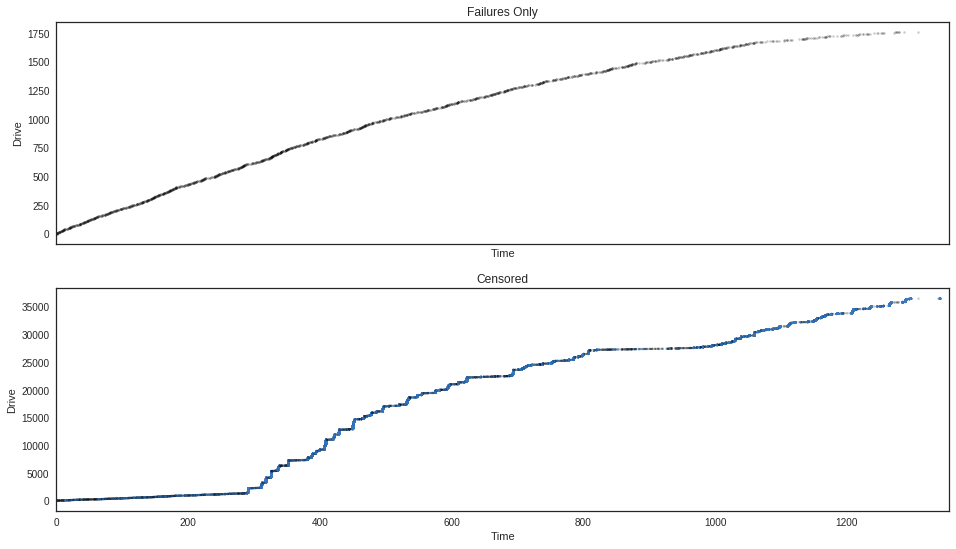

In [20]:
ttf_cen_sorted = sorted(zip(ttf_cen, u_train_cen))
ttf_cen_sorted, u_train_cen_sorted= [a[0] for a in ttf_cen_sorted],[a[1] for a in ttf_cen_sorted]

sns.set_style("white")
sns.despine(offset=10, trim=True);
u_colors_cen_sorted = [colorp[0] if c==1 else colorp[1] for c in u_train_cen_sorted]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
ax1.scatter(sorted(ttf), range(len(ttf)), c=colorp[1], s=4, alpha=.2)
ax2.scatter(ttf_cen_sorted, range(len(ttf_cen_sorted)), c = u_colors_cen_sorted, s=4, alpha=.2)
ax1.set_ylabel('Drive')
ax2.set_ylabel('Drive')
ax1.set_title("Failures Only")
ax2.set_title("Censored")
ax2.set_xlabel('Time')
ax1.set_xlabel('Time')
ax1.set_xlim([0, 1.01*ttf_cen.max()])
ax2.set_xlim([0, 1.01*ttf_cen.max()])
plt.show()

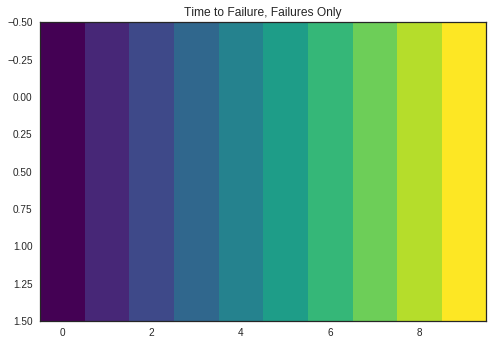

In [46]:

#mttf = ttf[:,ttf.argsort(),0].T
plt.imshow( [np.linspace(-10,10,10),  np.linspace(-10,10,10)], interpolation='nearest', aspect='auto', cmap="viridis")
#plt.imshow( [sorted(ttf),  range(len(ttf))], interpolation='nearest', aspect='auto', cmap="viridis")
plt.title('Time to Failure, Failures Only')
plt.show()

#plt.imshow(np.sum(feature_data,2)[:,seq_lengths.argsort()].T,interpolation='nearest', aspect='auto')
#plt.title('feature mean per sequence')
#plt.show()

#plt.imshow(np.sum(feature_data,2)[:,:].T,interpolation='nearest', aspect='auto')
#plt.title('feature mean per sequence, unsorted')
#plt.show()

#plt.hist(seq_lengths,20)
#plt.title('Distribution of sequence lengths for data')
#plt.show()

Define fit with tensorflow and define a a penalty for beta.

In [4]:
def betapenalty_alt(b, location = 10.0, growth=20.0, output_collection=(), name=None):
    """Returns a positive penalty term exploding when beta approaches location.

    Adding this term to the loss may prevent overfitting and numerical instability
    of large values of beta (overconfidence). Remember that loss = -loglik+penalty

    Args:
        b:  beta.  Positive nonzero `Tensor` of type `float32`, `float64`.
        output_collection: `tuple` of `string`s, name of the collection to
                          collect result of this op.
        name: `string`, name of the operation.

    Returns:
        A positive `Tensor` of same shape as `b` being a penalty term
    """
    with tf.name_scope(name, "weibull_betapenalty", [b]):
        scale = growth/location
        penalty = tf.exp(scale*(b-location))
        tf.add_to_collection(output_collection, penalty)

    return(penalty)


def tf_loglik_runner(loglik_fun, tte, tte_mask, n_steps = 2000):    
    y_ = tf.placeholder(tf.float32, shape=(None, 1))
    u_ = tf.placeholder(tf.float32, shape=(None, 1))
    
    # odd inital a for odd data
    a_guess = np.max(tte)
    a = tf.exp(tf.Variable(tf.random_normal([1], mean=a_guess, stddev=1.0), name='a_weight'))
    b = tf.exp(tf.Variable(tf.random_normal([1],mean= 1.0 , stddev=1.0), name='b_weight'))
     
    # added this betapenalty
    loglik = loglik_fun(a, b, y_,u_) 
    penalty = betapenalty_alt(b)
    loss = -tf.reduce_mean(loglik) + penalty
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.000001)
    
    train_step = optimizer.minimize(loss)
    sess = tf.Session()
    
    sess.run(tf.global_variables_initializer())

    for step in range(n_steps):
        loss_val,_,a_val,b_val= sess.run([loss,train_step, a,b],feed_dict={y_: tte, u_ : tte_mask})
        if step % 250 == 0:
            print("Step: %f, Loss value %s" % (step,loss_val))
            print ("Step: %f, A: %f B: %f" % (step,a_val, b_val))
    
    return a_val, b_val

discreteize data and shape it correctly for tensorflow

In [5]:
ttf_cen = np.floor(ttf_cen)
ttf_cen_s = [[x] for x in ttf_cen]
u_train_cen_s =  [[x] for x in  u_train_cen]

ttf_f = np.floor(ttf)
ttf_f_s = [[x] for x in ttf_f]
u_train_f_s =  [[x] for x in  u_train]

In [6]:
n_fit_steps = 2000


a_val_cen, b_val_cen = tf_loglik_runner(loglik_discrete, ttf_cen_s, u_train_cen_s, 
                                        n_steps = n_fit_steps)
print ("Cesnored case A: %f B: %f" % (a_val_cen[0], b_val_cen[0]))

a_val_f, b_val_f = tf_loglik_runner(loglik_discrete, ttf_f_s, u_train_f_s, 
                                        n_steps = n_fit_steps)
print ("Failures only case A: %f B: %f" % (a_val_f[0], b_val_f[0]))


Step: 0.000000, Loss value [ nan]
Step: 0.000000, A: inf B: 3.107906
Step: 250.000000, Loss value [ nan]
Step: 250.000000, A: nan B: nan
Step: 500.000000, Loss value [ nan]
Step: 500.000000, A: nan B: nan
Step: 750.000000, Loss value [ nan]
Step: 750.000000, A: nan B: nan
Step: 1000.000000, Loss value [ nan]
Step: 1000.000000, A: nan B: nan
Step: 1250.000000, Loss value [ nan]
Step: 1250.000000, A: nan B: nan
Step: 1500.000000, Loss value [ nan]
Step: 1500.000000, A: nan B: nan
Step: 1750.000000, Loss value [ nan]
Step: 1750.000000, A: nan B: nan
Cesnored case A: nan B: nan
Step: 0.000000, Loss value [ nan]
Step: 0.000000, A: inf B: 3.348879
Step: 250.000000, Loss value [ nan]
Step: 250.000000, A: nan B: nan
Step: 500.000000, Loss value [ nan]
Step: 500.000000, A: nan B: nan
Step: 750.000000, Loss value [ nan]
Step: 750.000000, A: nan B: nan
Step: 1000.000000, Loss value [ nan]
Step: 1000.000000, A: nan B: nan
Step: 1250.000000, Loss value [ nan]
Step: 1250.000000, A: nan B: nan
Step: 

Total fail. So lets just guess some Weibull params.

In [7]:
b_val_f = 1.0
a_val_f = np.median(ttf)
W_f = np.sort(a_val_f * np.power(-np.log(np.linspace(1e-10,1.,len(ttf))),1.0/b_val_f))
W = np.sort(a_val_f * np.power(-np.log(np.linspace(1e-10,1.,len(ttf_cen_sorted))),1.0/b_val_f))

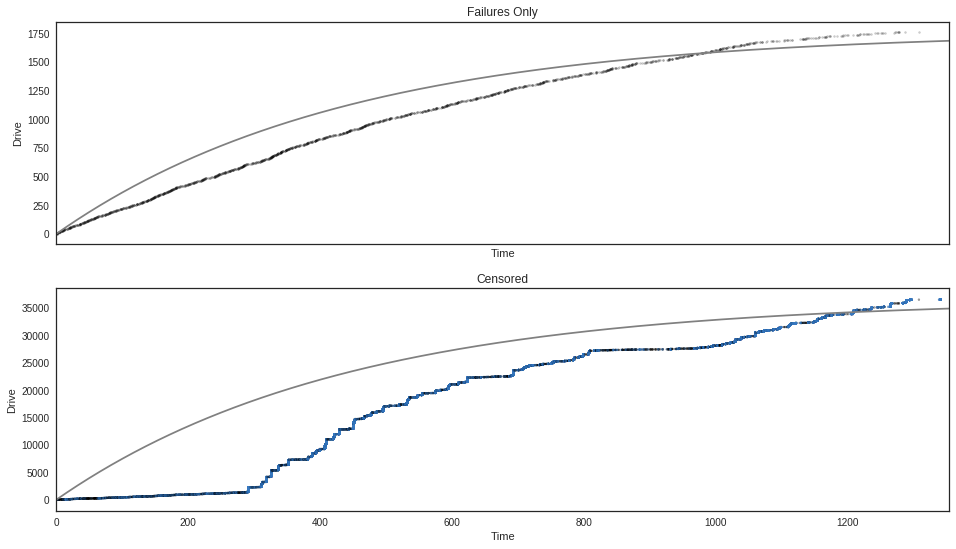

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
ax1.scatter(sorted(ttf), range(len(ttf)), c=colorp[1], s=4, alpha=.2)
ax1.plot(W_f, range(len(ttf)), c="grey")
ax2.scatter(ttf_cen_sorted, range(len(ttf_cen_sorted)), c = u_colors_cen_sorted, s=4, alpha=.2)
ax2.plot(W, range(len(ttf_cen)), c="grey")
ax2.scatter(ttf_cen_sorted, range(len(ttf_cen_sorted)), c = u_colors_cen_sorted, s=4, alpha=.2)
ax1.set_ylabel('Drive')
ax2.set_ylabel('Drive')
ax1.set_title("Failures Only")
ax2.set_title("Censored")
ax2.set_xlabel('Time')
ax1.set_xlabel('Time')
ax1.set_xlim([0, 1.01*ttf_cen.max()])
ax2.set_xlim([0, 1.01*ttf_cen.max()])
plt.show()